<a href="https://colab.research.google.com/github/sberniz/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [8]:
#Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import category_encoders as ce
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix,accuracy_score, average_precision_score,classification_report
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [9]:
#Data Cleaning and Feature Selections 
train,val = train_test_split(train,train_size=0.80, test_size=0.20,stratify=train['status_group'],random_state=42)
#Wrangle Function
def wrangle(df):
  X = df.copy()
  X['latitude'] = X['latitude'].replace(-2e-08,0) #replace small numbers with 0 
  cols_with_zeros = ['latitude','longitude','population','construction_year']
  for col in cols_with_zeros:   
    X[col] = X[col].replace(0,np.NaN) #replace 0 with NaN
  X = X.drop(columns=['quantity_group','payment_type','extraction_type_group']) #repeated

  return X
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

def feat_ad(df):
  df['date_recorded'] = pd.to_datetime(df['date_recorded'],infer_datetime_format=True)
  
  df['month_recorded'] = df['date_recorded'].dt.month
  df['day_recorded'] = df['date_recorded'].dt.day
  df['year_recorded'] = df['date_recorded'].dt.year
  df['years'] = df['year_recorded'] - df['construction_year']
  df['years_missing'] = df['years'].isnull()
  df['date_recorded'] = df['date_recorded'].dt.strftime('%Y-%m-%d')
 
  return df
train = feat_ad(train)
val = feat_ad(val)
test = feat_ad(test)

#feature selection 
target = 'status_group'
train_features = train.drop(columns=[target,'id'])

numeric_features = train_features.select_dtypes(include='number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 90].index.tolist()

features = numeric_features + categorical_features
print(features)

X_train = train[features]
X_val = val[features]
X_test = test[features]
y_train = train[target]
y_val = val[target]


['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'month_recorded', 'day_recorded', 'year_recorded', 'years', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_class', 'management', 'management_group', 'payment', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'years_missing']


In [11]:
train['date_recorded'].dtypes

dtype('O')

In [12]:
#Pipeline with best prediction so far. in accuracy score
model3 = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                       SimpleImputer(strategy='mean'),
                       StandardScaler(),
                       RandomForestClassifier(n_estimators=300,max_features=19,criterion='entropy',random_state=58)

                       )
model3.fit(X_train,y_train)
y_pred = model3.predict(X_val)
print("Validation accuracy:",accuracy_score(y_val,y_pred))











Validation accuracy: 0.8111111111111111


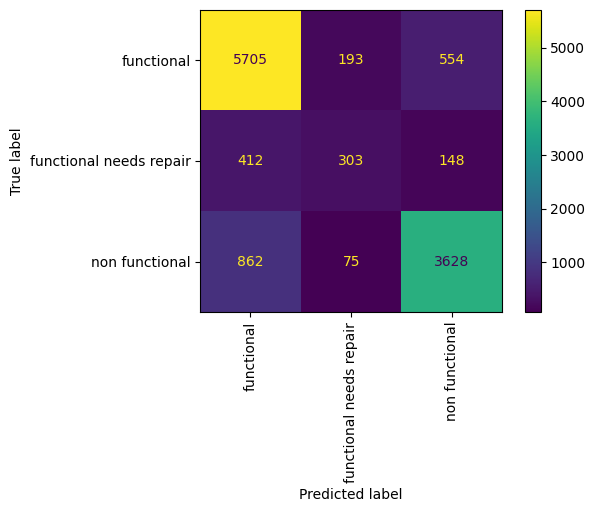

In [13]:
#Plot confusion matrix
plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(model3,X_val,y_val,values_format='.0f',xticks_rotation='vertical')

In [14]:
confusion_matrix(y_val,y_pred)

array([[5705,  193,  554],
       [ 412,  303,  148],
       [ 862,   75, 3628]])

In [15]:
matrix = confusion_matrix(y_val,y_pred)

In [16]:
#correct predictions
correct_pred = matrix[0,0] + matrix[1,1] + matrix[2,2]
correct_pred

9636

In [17]:
#total_pred
total_pred = matrix.sum()
total_pred

11880

In [18]:
#CLassification accuracy matches
correct_pred /total_pred

0.8111111111111111

In [19]:
#classification Report
print(classification_report(y_val,y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.88      0.85      6452
functional needs repair       0.53      0.35      0.42       863
         non functional       0.84      0.79      0.82      4565

               accuracy                           0.81     11880
              macro avg       0.73      0.68      0.70     11880
           weighted avg       0.80      0.81      0.81     11880



In [20]:
#Binary try
y_train2 = y_train !='functional'
y_val2 = y_val != 'functional'

In [21]:
#Model Training for Binary
#Pipeline with best prediction so far. in accuracy score
model4 = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                       SimpleImputer(strategy='mean'),
                       StandardScaler(),
                       RandomForestClassifier(n_estimators=300,max_features=19,criterion='entropy',random_state=58)

                       )
model4.fit(X_train,y_train2)
y_pred2 = model4.predict(X_val)
print("Validation accuracy:",accuracy_score(y_val2,y_pred2))

Validation accuracy: 0.826936026936027


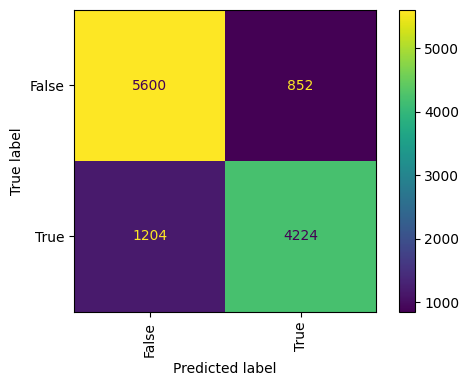

In [22]:
plot_confusion_matrix(model4,X_val,y_val2,values_format='.0f',xticks_rotation='vertical')

In [23]:
recall = 4224 / (4224  + 1204)
recall

0.7781871775976419

In [24]:
print(classification_report(y_val2,y_pred2))

              precision    recall  f1-score   support

       False       0.82      0.87      0.84      6452
        True       0.83      0.78      0.80      5428

    accuracy                           0.83     11880
   macro avg       0.83      0.82      0.82     11880
weighted avg       0.83      0.83      0.83     11880



In [25]:
y_pred_proba = model4.predict_proba(X_val)

In [26]:
print(y_pred_proba)

[[0.22333333 0.77666667]
 [0.56       0.44      ]
 [0.83333333 0.16666667]
 ...
 [0.49666667 0.50333333]
 [0.49666667 0.50333333]
 [0.00666667 0.99333333]]


In [27]:
random_inspections = 2000
print(f'With {random_inspections} random inspections, we expect to repair {0.46*random_inspections} waterpumps')

With 2000 random inspections, we expect to repair 920.0 waterpumps


In [28]:
threshold = .925
y_pred_prec = y_pred_proba[:-1] >threshold

In [29]:
y_pred_prec

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [False, False]])

In [30]:
results = pd.DataFrame({'y_val':y_val2,'y_pred_prob':y_pred_proba[:,-1]})
top2000 = results.sort_values(by='y_pred_prob',ascending=False)[:2000]
top2000.head()

,y_val,y_pred_prob
32684,True,1.0
51103,True,1.0
53172,True,1.0
6837,True,1.0
19621,True,1.0


In [31]:
trips = 2000
print(f'Baseline:{trips * 0.46} waterpump repairs in {trips} trips')
relevant_recomendations = top2000['y_val'].sum()
print(f'With model:predict {relevant_recomendations} waterpump repair in {trips} trips')

Baseline:920.0 waterpump repairs in 2000 trips
With model:predict 1969 waterpump repair in 2000 trips


In [32]:
#model for search
model6 = make_pipeline(ce.OneHotEncoder(),
                       SimpleImputer(),
                       RandomForestClassifier(random_state=58)

)

In [84]:
#RandomizedSearchCV
param_distributions = {
    'simpleimputer__strategy': ['mean'],
    'randomforestclassifier__criterion':['gini','entropy'],
    'randomforestclassifier__n_estimators':range(1,320),
}
search = RandomizedSearchCV(model6,
                            param_distributions=param_distributions,
                            n_iter=50,
                            cv=3,
                            scoring='accuracy',
                            verbose=10,
                            return_train_score=True,
                            random_state = 58,
                            
                            n_jobs=-1
                            )
search.fit(X_train,y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.7s


KeyboardInterrupt: ignored

In [78]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'mean', 'randomforestclassifier__random_state': 47, 'randomforestclassifier__n_estimators': 281, 'randomforestclassifier__max_features': 29, 'randomforestclassifier__max_depth': 19, 'randomforestclassifier__criterion': 'entropy'}
Cross-validation accuracy 0.8030513468013468


In [79]:
search.score(X_train,y_train)

0.9249158249158249

In [80]:
search.score(X_val,y_val)

0.8102693602693603

In [81]:
y_val_pred = search.predict(X_val)

In [82]:
accuracy_score(y_val,y_val_pred)

0.8102693602693603

In [74]:
model5 = make_pipeline(ce.OneHotEncoder(),
                       SimpleImputer(),
                       RandomForestClassifier(n_estimators=279,max_features=19,max_depth=80,criterion='gini',random_state=42))

In [75]:
model5.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'recorded_by', 'scheme_management',
                                     'permit', 'extraction_type',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'water_quality', 'quality_group',
                                     'quantity', 'source', 'source_type',
                                     'source_class', 'waterpoint_type',
                                     'waterpoint_type_group'],...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=80, max_features=19,
                                        max_leaf_nodes=None, max_samples=None,
      

In [76]:
model5.score(X_train,y_train),model5.score(X_val,y_val)

(0.9979377104377104, 0.8118686868686869)

In [88]:
y_pred5 = model5.predict(X_test)

In [89]:
submission = sample_submission.copy()
submission['status_group'] = y_pred5
submission.to_csv('sub6.csv',index=False)